In [4]:
import torch
from torch.utils.data import TensorDataset
from sklearn.metrics import roc_auc_score

In [5]:
features = torch.load('C:/Users/user/features.pt')

In [6]:
import numpy as np

labels_path = "C:/Users/user/labels.npy"

# Load the labels array from the .npy file
labels = np.load(labels_path)

# Print the shape and contents of the loaded array
print("Array Shape:", labels.shape)
print("Array Contents:", labels)

Array Shape: (94003,)
Array Contents: [1. 1. 1. ... 0. 0. 0.]


In [7]:
# Load labels from npy file
labels_np = np.load('C:/Users/user/labels.npy')

# Convert labels to tensors
labels = torch.from_numpy(labels_np)

# Verify the type of the resulting tensor
print(type(labels))

<class 'torch.Tensor'>


In [10]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv

In [11]:
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.4, random_state=42)

In [12]:
x_train

tensor([[-1.8507, -2.3431,  1.6074,  ..., -1.5637, -1.4387, -0.3762],
        [ 0.4563, -1.0095, -1.5173,  ..., -1.0800, -0.6277,  0.5689],
        [-1.8575, -2.3382,  1.9552,  ..., -1.9780, -0.8690, -0.4288],
        ...,
        [-4.2447, -1.6035,  0.1674,  ..., -3.2275, -0.0912,  0.0912],
        [-4.8019, -1.4592, -3.4100,  ..., -1.6698, -1.4332,  1.3856],
        [-1.2754,  0.8163,  1.2229,  ..., -2.6263, -0.3825,  0.2383]])

In [13]:
y_train

tensor([1., 1., 1.,  ..., 0., 1., 1.], dtype=torch.float64)

In [14]:
val = np.unique(y_train)
val

array([0., 1.])

In [15]:
type(x_train)

torch.Tensor

In [16]:
type(y_train)

torch.Tensor

In [17]:
len(x_train)

65802

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Define custom dataset
class UCFCrimeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y

# Define GCN feature extractors, EDL model, and normalizing flow model
class GCNFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNFeatureExtractor, self).__init__()
        # Define GCN layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        
    def forward(self, x, edge_index):
        # Implement the forward pass of the GCN feature extractor
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        return x

class EDLModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EDLModel, self).__init__()
        # Define EDL layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Implement the forward pass of the EDL model
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  
        return x

class NormalizingFlowModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(NormalizingFlowModel, self).__init__()
        # Normalizing flow layers
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        
        for _ in range(num_layers):
            self.layers.append(nn.Linear(input_dim, hidden_dim))
        
    def forward(self, x):
        # Implement the forward pass of the normalizing flow model
        for layer in self.layers:
            x = layer(x)
            x = torch.relu(x)
        return x

class MILModel(nn.Module):
    def __init__(self, gcn_fe_extractor, edl_model, nf_model):
        super(MILModel, self).__init__()
        self.gcn_fe_extractor = gcn_fe_extractor
        self.edl_model = edl_model
        self.nf_model = nf_model
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x, edge_index):
        x = self.gcn_fe_extractor(x, edge_index)
        x = self.edl_model(x)
        x = self.nf_model(x)
        x = self.dropout(x)
        return x

def weakly_supervised_mil_loss(y_true, y_pred):

    # Use Binary Cross Entropy loss
    mil_loss = F.cross_entropy(y_pred, y_true)

    return mil_loss

def lmil_ltriplet_loss(edl_outputs, batch_labels, embeddings, m=0.2):
    # Weakly-Supervised MIL Loss (Binary Cross-Entropy Loss)
    mil_loss = weakly_supervised_mil_loss(batch_labels, edl_outputs)

    valid_instances = batch_labels.unique()
    if len(valid_instances) < 2:
        # Skip batch if there are less than two unique instances (cannot form anchor and positive pair)
        return mil_loss
    
    # Sample triplet instances based on batch_labels (anchor, positive, and negative instances)
    anchor = embeddings[batch_labels].unsqueeze(1)
    
    # Ensure positive and negative samples are different instances
    positive_idx = torch.randint(0, len(valid_instances), (len(valid_instances),))
    negative_idx = torch.randint(0, len(valid_instances), (len(valid_instances),))

    while torch.any(positive_idx == negative_idx):
        negative_idx[positive_idx == negative_idx] = torch.randint(0, len(valid_instances), (torch.sum(positive_idx == negative_idx),))

    positive = embeddings[valid_instances[positive_idx]]
    negative = embeddings[valid_instances[negative_idx]]

    # Compute Euclidean distances between instances
    distance = torch.nn.PairwiseDistance(p=2)  # Euclidean distance
    dap = distance(anchor, positive)
    dan = distance(anchor, negative)

    # Calculate triplet loss based on the given formula
    triplet_loss = torch.relu(dap - dan + m).mean()

    # Can choose a trade-off parameter (e.g., alpha) to balance the contributions of both losses.
    # For example, the total loss can be defined as a linear combination of both losses:
    alpha = 0.5
    total_loss = alpha * mil_loss + (1 - alpha) * triplet_loss

    return total_loss

In [19]:
print("X_train shape is: \n", x_train.shape)
print("\n Y_train shape is: \n", y_train.shape)
print("\n X_test shape is: \n", x_test.shape)
print("\n Y_test shape is: \n", y_test.shape)
print("\n X_val shape is: \n", x_val.shape)
print("\n Y_val shape is: \n", y_val.shape)

X_train shape is: 
 torch.Size([65802, 1000])

 Y_train shape is: 
 torch.Size([65802])

 X_test shape is: 
 torch.Size([11281, 1000])

 Y_test shape is: 
 torch.Size([11281])

 X_val shape is: 
 torch.Size([16920, 1000])

 Y_val shape is: 
 torch.Size([16920])


In [20]:
len(x_train)

65802

In [21]:
# Initialize the models and move them to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
import torch

def calculate_edge_index(x_train, y_train, x_test, y_test):
    edge_index_train = []
    edge_index_test = []
    #def gen_edge_index_train():
    for i in range(len(x_train)):
        for j in range(i + 1, len(x_train)):
            if y_train[i] == y_train[j]:
                edge_index_train.append((i, j))
                edge_index_train.append((j, i))
                        
    #def gen_edge_index_test():
    for i in range(len(x_test)):
        for j in range(i + 1, len(x_test)):
            if y_test[i] == y_test[j]:
                edge_index_test.append((i, j))
                edge_index_test.append((j, i))

    # Convert the edge index to a list of tuples.
    edge_index_train = list(edge_index_train)
    edge_index_test = list(edge_index_test)

    # Combine the train and test edge indices.
    edge_index = edge_index_train + edge_index_test

    # Convert the edge index to a torch tensor.
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    
    # Clamping the edge_index to [0, 4]
    edge_index = torch.clamp(edge_index, 0, 4)

    return edge_index

In [23]:
edge_index = calculate_edge_index(x_train[:20000], y_train[:20000], x_val[:10000], y_val[:10000])

In [25]:
edge_index.shape

torch.Size([319986050, 2])

In [26]:
edge_index = edge_index.transpose(0, 1)

In [27]:
edge_index.shape

torch.Size([2, 319986050])

In [28]:
x_train[:10]

tensor([[-1.8507, -2.3431,  1.6074,  ..., -1.5637, -1.4387, -0.3762],
        [ 0.4563, -1.0095, -1.5173,  ..., -1.0800, -0.6277,  0.5689],
        [-1.8575, -2.3382,  1.9552,  ..., -1.9780, -0.8690, -0.4288],
        ...,
        [-0.2824, -2.0713, -2.4768,  ...,  0.9428,  0.0852, -1.0849],
        [-4.3647, -1.9255, -2.8647,  ..., -1.7640, -1.3637,  1.7980],
        [-1.5663, -0.8748, -1.3458,  ..., -2.1948,  0.1826, -0.3837]])

In [29]:
batch_size = 40

# Create custom datasets and data loaders
train_dataset = UCFCrimeDataset(x_train[:20000], y_train[:20000])
val_dataset = UCFCrimeDataset(x_val[:10000], y_val[:10000])
test_dataset = UCFCrimeDataset(x_test[:6000], y_test[:6000])


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
input_dim = 1000
hidden_dim = 1000
output_dim = 1000
num_epochs = 50
m = 0.5

In [31]:
# Initialize models
gcn_fe_extractor = GCNFeatureExtractor(input_dim, hidden_dim=256, output_dim=1000).to(device)
edl_model = EDLModel(output_dim, hidden_dim, output_dim).to(device)
normalizing_flow_model = NormalizingFlowModel(input_dim, hidden_dim, num_layers=5).to(device)
mil_model = MILModel(gcn_fe_extractor, edl_model,normalizing_flow_model).to(device)

# Define loss function and optimizer
criterion = lmil_ltriplet_loss
optimizer = optim.Adam(mil_model.parameters(), lr=0.0001)

   """
   Early stopping function.
   Stops the training if validation loss does not improve for `patience` number of consecutive epochs.

   """

In [32]:
def early_stopping(val_loss, patience=3):
    if len(val_loss) <= patience:
        return False
    
    for i in range(1, patience + 1):
        if val_loss[-i] > val_loss[-i - 1]:
            return True
        
    return False

# Training loop
best_val_loss = float('inf')
patience = 3
val_loss_history = []
verbose = True

# Initialize lists to store accuracy values
train_accuracy_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    mil_model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    predicted_probs = []
    true_labels = []

    for batch_data, batch_labels in train_loader:
        batch_data = batch_data.to(device) 
        edge_index = edge_index.to(device) # Move edge indices to device
        batch_labels = batch_labels.to(device) # Move labels to device
        optimizer.zero_grad()

        # Forward pass through GCN feature extractor
        embeddings = gcn_fe_extractor(batch_data, edge_index)
        
        # Forward pass
        output = mil_model(batch_data, edge_index)
        edl_outputs = edl_model(output)

        # Compute loss
        loss = criterion(edl_outputs,batch_labels.long(), embeddings, m=0.2)

        # Backward pass and optimization
        loss.backward(retain_graph=True)
        optimizer.step()

        edl_outputs = edl_model(output)
        train_loss += loss.item()
        _, predicted = torch.max(edl_outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

        # Collect predicted probabilities and true labels for AUC-ROC calculation
        predicted_probs.extend(torch.softmax(edl_outputs, dim=1)[:, 1].detach().cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

    train_loss /= len(train_loader)
    accuracy = correct / total

    # Calculate AUC-ROC percentage
    auc_roc = roc_auc_score(true_labels, predicted_probs) * 100
    
    if verbose: 
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Train Accuracy: {accuracy:.4f} | AUC-ROC: {auc_roc:.2f}%")

    # Validation
    mil_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predicted_probs = []
    val_true_labels = []

    with torch.no_grad():
        for val_batch_data, val_batch_labels in val_loader:
            val_batch_data = val_batch_data.to(device)
            edge_index = edge_index.to(device)
            val_batch_labels = val_batch_labels.to(device)
            
            # Forward pass through GCN feature extractor
            embeddings = gcn_fe_extractor(val_batch_data, edge_index)

            val_output = mil_model(val_batch_data, edge_index)
            val_edl_outputs = edl_model(val_output)

            val_loss += criterion(val_edl_outputs, val_batch_labels.long(), embeddings, m=0.2).item()
            _, val_predicted = torch.max(val_edl_outputs.data, 1)
            val_total += val_batch_labels.size(0)
            val_correct += (val_predicted == val_batch_labels).sum().item()

            # Collect predicted probabilities and true labels for AUC-ROC calculation
            val_predicted_probs.extend(torch.softmax(val_edl_outputs, dim=1)[:, 1].detach().cpu().numpy())
            val_true_labels.extend(val_batch_labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_loss_history.append(val_loss)
    
    train_accuracy_history.append(accuracy)
    val_accuracy_history.append(val_accuracy)
    
    # Calculate AUC-ROC percentage
    val_auc_roc = roc_auc_score( val_true_labels, val_predicted_probs) * 100

    if verbose:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | AUC-ROC: {val_auc_roc:.2f}% \n")

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if early_stopping(val_loss_history, patience):
        print("Early stopping triggered!")
        break

Epoch [1/50] | Train Loss: 0.3373 | Train Accuracy: 0.8635 | AUC-ROC: 91.16%
Epoch [1/50] | Validation Loss: 0.1325 | Validation Accuracy: 0.9761 | AUC-ROC: 99.70% 

Epoch [2/50] | Train Loss: 0.1358 | Train Accuracy: 0.9745 | AUC-ROC: 99.52%
Epoch [2/50] | Validation Loss: 0.1259 | Validation Accuracy: 0.9783 | AUC-ROC: 99.78% 

Epoch [3/50] | Train Loss: 0.1285 | Train Accuracy: 0.9767 | AUC-ROC: 99.69%
Epoch [3/50] | Validation Loss: 0.1240 | Validation Accuracy: 0.9786 | AUC-ROC: 99.78% 

Epoch [4/50] | Train Loss: 0.1295 | Train Accuracy: 0.9757 | AUC-ROC: 99.68%
Epoch [4/50] | Validation Loss: 0.1239 | Validation Accuracy: 0.9759 | AUC-ROC: 99.79% 

Epoch [5/50] | Train Loss: 0.1266 | Train Accuracy: 0.9760 | AUC-ROC: 99.72%
Epoch [5/50] | Validation Loss: 0.1240 | Validation Accuracy: 0.9779 | AUC-ROC: 99.80% 

Early stopping triggered!


In [33]:
import matplotlib.pyplot as plt

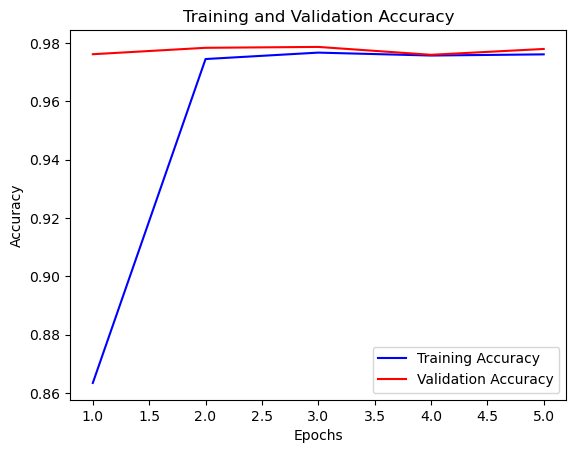

In [34]:
# Plot accuracy graph
epochs = range(1, len(train_accuracy_history) + 1)

plt.plot(epochs, train_accuracy_history, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
edge_index1 = calculate_edge_index(x_train[:20000], y_train[:20000], x_test[:6000], y_test[:6000])

In [36]:
edge_index1 = edge_index1.transpose(0, 1)

In [39]:
#TESTING
mil_model.eval()

test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_batch_data, test_batch_labels in test_loader:
        test_batch_data = test_batch_data.to(device) 
        edge_index1 = edge_index1.to(device)  # Move edge indices to device
        test_batch_labels = test_batch_labels.to(device)  # Move labels to device

        # Forward pass
        output = mil_model(test_batch_data, edge_index1)
        test_edl_outputs = edl_model(output)

        # Forward pass through GCN feature extractor
        embeddings = gcn_fe_extractor(test_batch_data, edge_index1)

        test_loss += criterion(test_edl_outputs, test_batch_labels.long(), embeddings, m=0.2).item()
        _, test_predicted = torch.max(test_edl_outputs.data, 1)
        test_total += test_batch_labels.size(0)
        test_correct += (test_predicted == test_batch_labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.4748 | Test Accuracy: 0.9770
